# Описание проекта <br>"Прогноз количества заказов для компании "Четенькое такси""

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

<b><u>Цель работы:</b></u><br>
Построить модель для предсказания объема заказов на следующий час

<b><u>Задачи:</b></u><br>
<ul><li>Загрузить данные</li>
<li>Выполнить первичный анализ и предобработку данных</li>
<li>Проанализировать количество заказов в разных временных интервалах</li>
<li>Провести анализ сдвигов и скользящих средних</li>
<li>Дополнить датафрейм признаками</li>
<li>Обучить и протестировать несколько моделей</li>
<li>Выявить лучшую по времени и метрике RMSE модель</li></ul>

<b><u>Описание данных:</b></u><br>
Датасет на 26496 строк. Количество заказов находится в столбце 'num_orders'

<h1>Содержание<span class="tocSkip"></span></h1>
1. <a href = '#Импорт-библиотек'>Импорт библиотек</a><br>
2. <a href = '#Загрузка-и-первичный-анализ-данных'>Загрузка и первичный анализ данных</a><br>
3. <a href = '#Обучение-моделей'>Обучение моделей</a><br>
4. <a href = '#Итоговый-вывод'>Итоговый вывод</a>

## Импорт билиотек

In [1]:
!pip3 install catboost
!pip install scikit-learn --upgrade -q

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
import os

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor 
import catboost as cb

from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split, TimeSeriesSplit 

from sklearn.metrics import make_scorer, mean_squared_error 
import time
from sklearn.pipeline import(
    Pipeline, 
    make_pipeline 
)
from sklearn.preprocessing import(
    OneHotEncoder,
    OrdinalEncoder, 
    LabelEncoder, 
    StandardScaler, 
    MinMaxScaler
)
from sklearn.compose import(
    make_column_selector, 
    make_column_transformer, 
    ColumnTransformer
)
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.tree import(DecisionTreeRegressor)
from catboost import(CatBoostRegressor)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Создание функций

In [3]:
# Сдвиг итерационно
def shift(data, target, start, finish, step): 
    for i in range(start, finish, step): 
        string = 'shift_' + str(i) 
        data[string] = data[target].shift(i)
    return data

In [4]:
# Скользящее среднее, сдвиг на 1 час итерационно
def rolling_mean_shift(data, target, start, finish, step): 
    for i in range(start, finish, step): 
        string = 'rolling_mean_' + str(i) + '_shift_1' 
        data[string] = data[target].shift().rolling(i).mean()
    return data

In [5]:
# Скользящее среднее итерационно
def rolling_mean(data, target, start, finish, step): 
    for i in range(start, finish, step): 
        string = 'rolling_mean_' + str(i) 
        data[string] = data[target].rolling(i).mean()
    return data

In [6]:
# Функция подготовки данных перед подбором моделей и их параметров
def data_preprocessing(data, target_name):
   
    # Разделение датафреймов на целевую и нецелевую выборку
    features = data.drop([target_name], axis=1)
    target = data[target_name]

    # Разделение целевой и нецелевой выборки на обучающие и тестовые выборки
    features_train,  features_test, target_train, target_test = train_test_split(
        features, 
        target, 
        test_size=.1, 
        shuffle=False, 
        random_state=42
    )
    
    return features_train,  features_test, target_train, target_test

In [7]:
# Создание структуры пайплайна
def params_and_model_selection(
    features_train, 
    features_test, 
    target_train, 
    target_test, 
    model_params
):
    
    start_time = time.time()
    
    # Стандартизация числовых значений
    numeric_transformer = make_pipeline(
        StandardScaler()
    )
    
    # Шаг препроцессинга в Пайплайне
    preprocessor = make_column_transformer(
        (numeric_transformer, features_train.columns)
    )
    
    # Pipeline
    pipe = Pipeline([
        ('preprocessor', preprocessor), 
        ('regressor', model_params[0]['regressor'][0])
    ])
    pipe.fit(features_train, target_train)
    
    smape_score = make_scorer(
        mean_squared_error, 
        squared=False 
    )
    
    # Кросс-валидация
    tscv = TimeSeriesSplit(n_splits=5) 
    
    # HalvingGridSearchCV
    grid = HalvingGridSearchCV(
        pipe, 
        model_params, 
        cv=tscv, 
        n_jobs=-1, 
        scoring=smape_score, 
        error_score='raise',  
        random_state=42
    )
    grid.fit(features_train, target_train)
    
    finish_time = time.time()
    funtion_time = finish_time - start_time
    
    return grid, funtion_time

In [8]:
def params_and_model_selection(
    features_train, 
    features_test, 
    target_train, 
    target_test, 
    model_params
):
    start_time = time.time()
    
    # Стандартизация числовых значений
    numeric_transformer = make_pipeline(
        StandardScaler()
    )
    
    # Шаг препроцессинга
    preprocessor = make_column_transformer(
        (numeric_transformer, features_train.columns)
    )
    
    # Pipeline
    pipe = Pipeline([
        ('preprocessor', preprocessor), 
        ('regressor', model_params[0]['regressor'][0])
    ])
    pipe.fit(features_train, target_train)
    
    # Определяем RMSE вручную
    rmse_scorer = make_scorer(
        lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))
    )
    
    # Кросс-валидация
    tscv = TimeSeriesSplit(n_splits=5) 
    
    # HalvingGridSearchCV
    grid = HalvingGridSearchCV(
        pipe, 
        model_params, 
        cv=tscv, 
        n_jobs=-1, 
        scoring=rmse_scorer, 
        error_score='raise',  
        random_state=42
    )
    grid.fit(features_train, target_train)
    
    finish_time = time.time()
    funtion_time = finish_time - start_time
    
    return grid, funtion_time

In [9]:
# печать результатов модели
def print_model_result(grids, data_times, model_name):
    print('Модель   :', model_name)
    print('RMSE     :', grids[-1].best_score_)
    print(f'Время    : {data_times[-1]} секунд')
    print('Параметры:\n', grids[-1].best_estimator_)

In [10]:
# Подготовка данных
def data_preprocessing(data, target_name):
    
    # Разделение датафреймов на целевую и нецелевую выборку
    features = data.drop([target_name], axis=1)
    target = data[target_name]

    # Разделение целевой и нецелевой выборки на обучающие и тестовые выборки
    features_train,  features_test, target_train, target_test = train_test_split(
        features, 
        target, 
        test_size=.1, 
        shuffle=False, 
        random_state=42
    )
    
    return features_train,  features_test, target_train, target_test

In [11]:
# LinearRegression
def grids_LinearRegression(
    features_train, 
    features_test, 
    target_train, 
    target_test, 
    grids, 
    data_times
):
    
    grid, time_best = params_and_model_selection(
        features_train, 
        features_test, 
        target_train, 
        target_test, 
        [{
            'regressor': [LinearRegression()] # score: R^2
        }]
    )
    
    grids.append(grid)
    data_times.append(time_best)
    
    return grids, data_times

In [12]:
# DecisionTreeRegressor
def grids_DecisionTreeRegressor(
    features_train, 
    features_test, 
    target_train, 
    target_test, 
    grids, 
    data_times
):
    
    grids_this = 0
    grids_best = 0
    funtion_time = 0
    time_best = 0
    
    # Поиск "regressor__max_depth"
    
    range_min = 1
    range_max = 201
    range_step = 20
    
    for i in range(1, 5, 1):
        # Поиск лучших параметров
        grids_this, funtion_time = params_and_model_selection(
            features_train, 
            features_test, 
            target_train, 
            target_test, 
            [{
                'regressor': [DecisionTreeRegressor(random_state=42)], # score: R^2
                'regressor__max_depth': range(
                    range_min, 
                    range_max, 
                    range_step
                )
            }]
        )
        # Выбор лучшей модели
        if grids_best == 0:
            grids_best = grids_this
            time_best = funtion_time
        elif grids_this.best_score_ > grids_best.best_score_:
            grids_best = grids_this
            time_best = funtion_time
        if range_step == 1: break
        # Выбор параметров поиска
        regressor__max_depth = grids_this.best_params_['regressor__max_depth']
        if int(regressor__max_depth - range_step / 2) > 0:
            range_min = int(regressor__max_depth - range_step / 2)
        else:
            range_min = regressor__max_depth
        range_max = int(regressor__max_depth + range_step / 2) + 1
        range_step = int(range_step / 2)
    
    grids.append(grids_best)
    data_times.append(time_best)
    
    return grids, data_times

In [13]:
# RandomForestRegressor
def grids_RandomForestRegressor(
    features_train, 
    features_test, 
    target_train, 
    target_test, 
    grids, 
    data_times
):
    
    grids_this = 0
    grids_best = 0
    funtion_time = 0
    time_best = 0
    
    # Поиск "regressor__max_depth"
    
    range_min = 20
    range_max = 61
    range_step = 20
    
    for i in range(1, 5, 1):
        
        
        # Поиск лучших параметров
        grids_this, funtion_time = params_and_model_selection(
            features_train, 
            features_test, 
            target_train, 
            target_test, 
            [{
                'regressor': [RandomForestRegressor(random_state=42)], # score: R^2
                'regressor__max_depth': range(
                    range_min, 
                    range_max, 
                    range_step
                ), 
                'regressor__n_estimators': [1]
            }]
        )
        # Выбор лучшей модели
        if grids_best == 0:
            grids_best = grids_this
            time_best = funtion_time
        elif grids_this.best_score_ > grids_best.best_score_: 
            grids_best = grids_this
            time_best = funtion_time
        if range_step == 1: break
        # Выбор параметров поиска
        regressor__max_depth = grids_this.best_params_['regressor__max_depth']
        if int(regressor__max_depth - range_step / 2) > 0:
            range_min = int(regressor__max_depth - range_step / 2)
        else:
            range_min = regressor__max_depth
        range_max = int(regressor__max_depth + range_step / 2) + 1
        range_step = int(range_step / 2)
        if range_step == 0: range_step = 1
    
    # Поиск "regressor__n_estimators"
    
    range_min = 10
    range_max = 31
    range_step = 10
    
    for i in range(1, 5, 1):
                
        # Поиск лучших параметров
        grids_this, funtion_time = params_and_model_selection(
            features_train, 
            features_test, 
            target_train, 
            target_test, 
            [{
                'regressor': [RandomForestRegressor(random_state=42)], # score: R^2
                'regressor__max_depth': [regressor__max_depth], 
                'regressor__n_estimators': range(
                    range_min, 
                    range_max, 
                    range_step
                )
            }]
        )
        # Выбор лучшей модели
        if grids_best == 0: 
            grids_best = grids_this
            time_best = funtion_time
        elif grids_this.best_score_ > grids_best.best_score_: 
            grids_best = grids_this
            time_best = funtion_time
        if range_step == 1: break
        # Выбор параметров поиска
        regressor__n_estimators = grids_this.best_params_['regressor__n_estimators']
        if int(regressor__n_estimators - range_step / 2) > 0:
            range_min = int(regressor__n_estimators - range_step / 2)
        else:
            range_min = regressor__n_estimators
        range_max = int(regressor__n_estimators + range_step / 2) + 1
        range_step = int(range_step / 10)
        if range_step == 0: range_step = 1
    
    grids.append(grids_best)
    data_times.append(time_best)
    
    return grids, data_times

In [14]:
# CatBoostRegressor
def grids_CatBoostRegressor(
    features_train, 
    features_test, 
    target_train, 
    target_test, 
    grids, 
    data_times
):
    
    # Поиск лучших параметров
    
    grids_best, time_best = params_and_model_selection(
        features_train, 
        features_test, 
        target_train, 
        target_test, 
        [{
            'regressor': [CatBoostRegressor()]
        }]
    )
    
    
    grids.append(grids_best)
    data_times.append(time_best)
    
    return grids, data_times

In [15]:
# Создание структуры пайплайна
def params_and_model_selection(
    features_train, 
    features_test, 
    target_train, 
    target_test, 
    model_params
):
    
    start_time = time.time()
    
    # Стандартизация числовых значений
    numeric_transformer = make_pipeline(
        StandardScaler()
    )
    
    # Шаг препроцессинга в Пайплайне
    preprocessor = make_column_transformer(
        (numeric_transformer, features_train.columns)
    )
    
    # Pipeline
    pipe = Pipeline([
        ('preprocessor', preprocessor), 
        ('regressor', model_params[0]['regressor'][0])
    ])
    pipe.fit(features_train, target_train)
    
    # Определяем RMSE вручную
    rmse_scorer = make_scorer(
        lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))
    )
    
    # Кросс-валидация специально для временных рядов
    tscv = TimeSeriesSplit(n_splits=5) 
    
    # HalvingGridSearchCV
    grid = HalvingGridSearchCV(
        pipe, 
        model_params, 
        cv=tscv, 
        n_jobs=-1, 
        scoring=rmse_scorer, 
        error_score='raise',
        random_state=42
    )
    grid.fit(features_train, target_train)
    
    finish_time = time.time()
    function_time = finish_time - start_time
    
    return grid, function_time

## Загрузка и первичный анализ данных

In [16]:
# Подгрузим датасет в переменную df

pth1 = '/taxi.csv'
pth2 = 'C:/Users/persc/Yandex.Disk/DataScience/Projects/Временные ряды/taxi.csv'
pth3 = '/datasets/taxi.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    df = pd.read_csv(pth2, index_col=[0], parse_dates=[0])
elif os.path.exists(pth3):
    df = pd.read_csv(pth3, index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')

In [17]:
# Посмотрим основную информацию о содержащихся данных
display(df.head(10))
display(df.tail(10))
df.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


,num_orders
datetime,
2018-08-31 22:20:00,48
2018-08-31 22:30:00,41
2018-08-31 22:40:00,34
2018-08-31 22:50:00,34
2018-08-31 23:00:00,30
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [18]:
df.describe() 

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Количество заказов за 10 минут лежит в диапазоне от 0 до 119. И если низкие значения не вызывают вопросов, то крайне высокие значения уже кажутся нереалистичными.<br>
В данных нет пропусков.

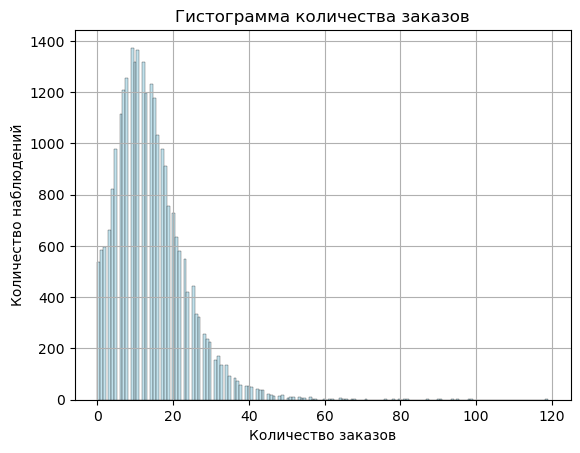

In [19]:
# Посмотрим на распределение количества заказов
plt.title('Гистограмма количества заказов')
plt.xlabel('Количество заказов')
plt.ylabel('Количество наблюдений')
plt.grid()
sns.histplot(df['num_orders'], color='lightblue');
plt.show()

Действительно, более 60 заказов за 10 минут - достаточно редкое явление для этого набора данных. Тем не менее, нам не известно сколько водителей в штате "Четенького такси", вполне возможно, что сервис справляется с объемом заказов >100.<br>
Количество заказов представленно целыми числами, небольшими значениями. Для удобства, приведем столбец к формату int32.

In [20]:
df['num_orders'] = df['num_orders'].astype('int32') 
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int32
dtypes: int32(1)
memory usage: 310.5 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проведем ресемплирование данных.

In [21]:
df = df.resample('1h').sum() 
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int32
dtypes: int32(1)
memory usage: 51.8 KB


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [22]:
print('Начало наблюдений:',df.index.min())
print('Конец наблюдений:',df.index.max())
print('Общее время наблюдений:',df.index.max() - df.index.min())
print()
df.describe()

Начало наблюдений: 2018-03-01 00:00:00
Конец наблюдений: 2018-08-31 23:00:00
Общее время наблюдений: 183 days 23:00:00



,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


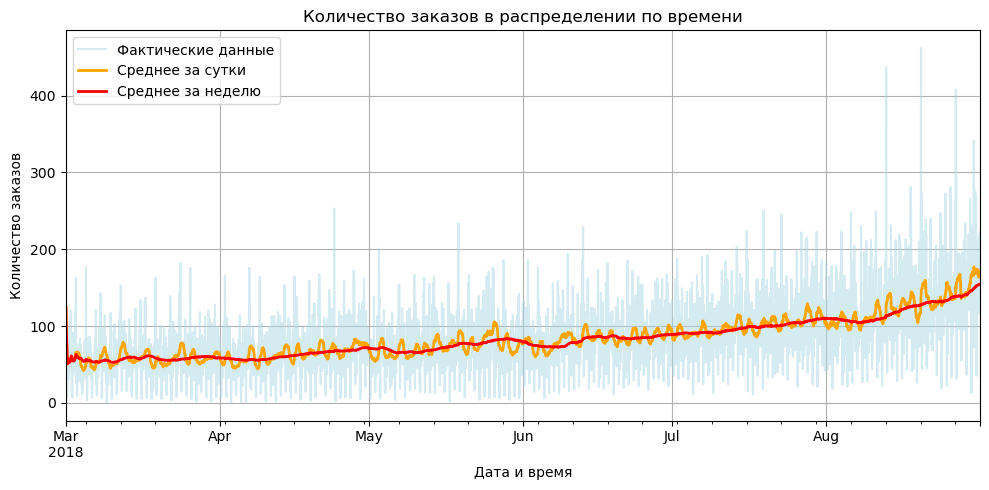

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))
df_renamed = df.rename(columns={'num_orders': 'Количество заказов'})

df_renamed['Количество заказов'].plot(color='lightblue', alpha=0.5, label='Фактические данные', ax=ax)

df_renamed['Суточное среднее'] = df_renamed['Количество заказов'].rolling('24h').mean()
df_renamed['Суточное среднее'].plot(color='orange', linewidth=2, label='Среднее за сутки', ax=ax)

df_renamed['Недельное среднее'] = df_renamed['Количество заказов'].rolling('7D').mean()
df_renamed['Недельное среднее'].plot(color='red', linewidth=2, label='Среднее за неделю', ax=ax)

plt.title('Количество заказов в распределении по времени')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Видно, что разброс по количеству заказов становится более широким ближе к осени. Пик приходится на середину-конец августа.

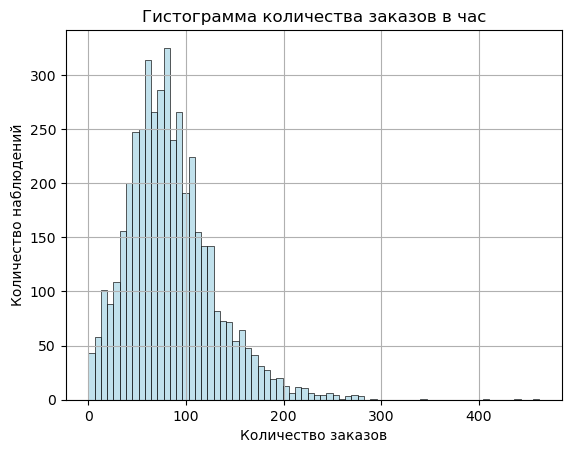

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [24]:
plt.title('Гистограмма количества заказов в час')
plt.xlabel('Количество заказов')
plt.ylabel('Количество наблюдений')
plt.grid()
sns.histplot(df['num_orders'], color='lightblue');
plt.show()
df.describe() 

Посмотрим на распределение данных в различных временных отрезках.

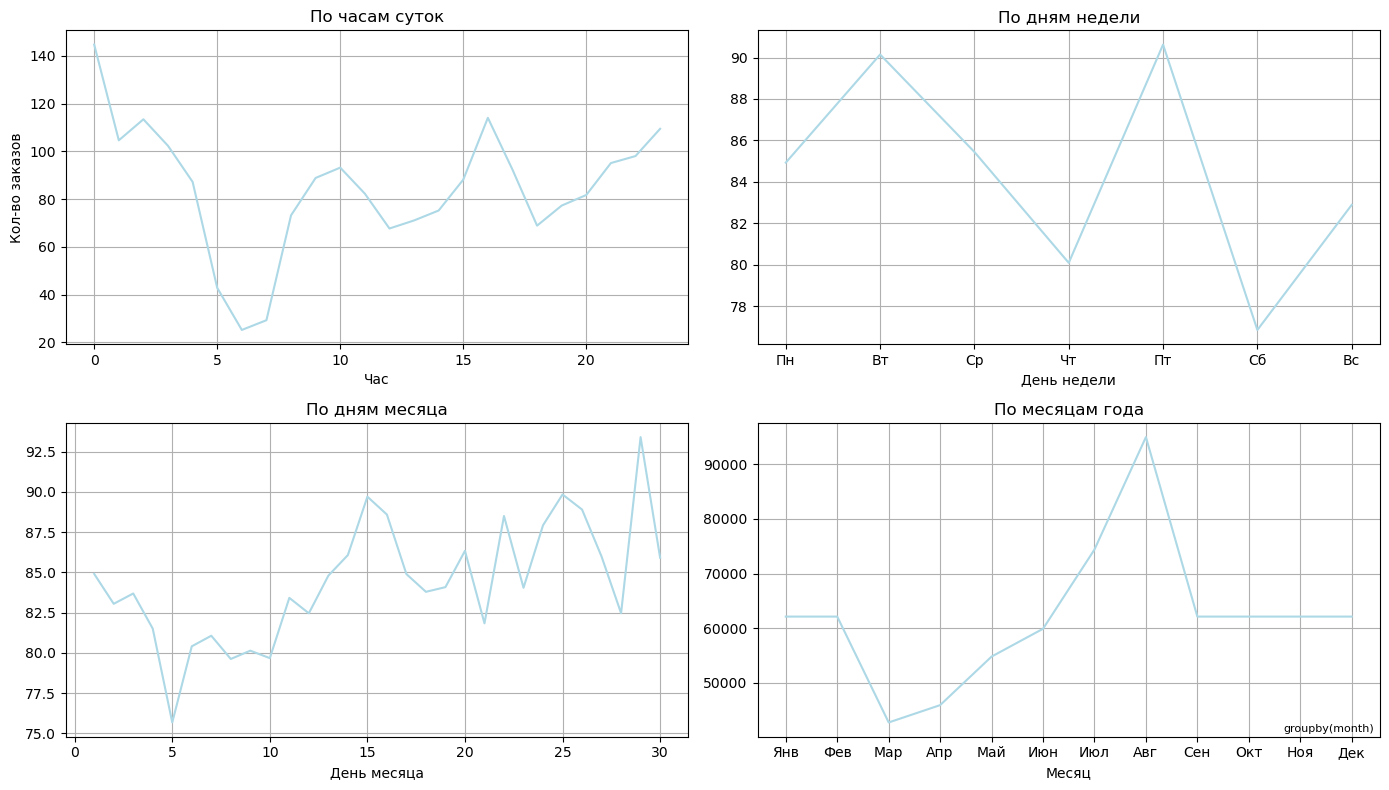

In [25]:
mean_orders = df['num_orders'].mean()

# Функция для извлечения сезонного паттерна
def get_seasonal_pattern(series, period, group_step, labels):
    result = seasonal_decompose(series, model='additive', period=period)
    seasonal_real = result.seasonal[:period] + mean_orders
    group_ids = np.arange(period) // group_step
    seasonal_by_group = pd.Series(seasonal_real.values).groupby(group_ids).mean()
    return pd.DataFrame({
        'label': labels,
        'value': seasonal_by_group.values[:len(labels)]
    })

# По часам суток
hours_labels = list(range(24))
df_hours = get_seasonal_pattern(df['num_orders'], period=24, group_step=1, labels=hours_labels)

# По дням недели
week_labels = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
df_week = get_seasonal_pattern(df['num_orders'], period=24*7, group_step=24, labels=week_labels)

# По дням месяца (условно 30 дней)
month_days_labels = list(range(1, 31))
df_month_days = get_seasonal_pattern(df['num_orders'], period=24*30, group_step=24, labels=month_days_labels)

# По месяцам года (условно 30 дней в месяце)
df_monthly = df['num_orders'].resample('ME').sum()
month_labels = ['Янв','Фев','Мар','Апр','Май','Июн','Июл','Авг','Сен','Окт','Ноя','Дек']
grouped_monthly = df_monthly.groupby(df_monthly.index.month).mean().reindex(range(1,13)).fillna(df_monthly.mean())
values_months = grouped_monthly.values
method_months = "groupby(month)"


fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axes[0, 0].plot(df_hours['label'], df_hours['value'], color='lightblue')
axes[0, 0].set_title('По часам суток')
axes[0, 0].set_xlabel('Час')
axes[0, 0].set_ylabel('Кол-во заказов')
axes[0, 0].grid(True)

axes[0, 1].plot(df_week['label'], df_week['value'], color='lightblue')
axes[0, 1].set_title('По дням недели')
axes[0, 1].set_xlabel('День недели')
axes[0, 1].grid(True)

axes[1, 0].plot(df_month_days['label'], df_month_days['value'], color='lightblue')
axes[1, 0].set_title('По дням месяца')
axes[1, 0].set_xlabel('День месяца')
axes[1, 0].grid(True)

axes[1, 1].plot(month_labels, values_months, color='lightblue')
axes[1, 1].set_title('По месяцам года')
axes[1, 1].set_xlabel('Месяц')
axes[1, 1].grid(True)
axes[1, 1].text(0.99, 0.01, method_months, ha='right', va='bottom', transform=axes[1,1].transAxes, fontsize=8)

plt.tight_layout()
plt.show()

* Количество заказов закономерно снижается к поздней ночи-раннему утру (5-7 часов).
* Четверг и суббота - самые непопулярные дни недели для вызова такси. Вторник и пятница - наоборот, наиболее популярные.
* Количество заказов увеличивается ближе к концу месяца.
* Тренд на увеличение количества заказов ближе к осени мы наблюдали ранее. Т.к. выборка представлена только за 1 неполный год, мы не можем наверняка утверждать, что подобная динамика присутствует и в других годах.

### Анализ сдвигов и скользящих средних

In [26]:
df_analisys = df.copy()  
df_analisys.head() 

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [27]:
# Сдвиг с разным количеством часов
df_analisys = shift(df_analisys, 'num_orders', 1, 25, 1)
df_analisys = shift(df_analisys, 'num_orders', 48, 169, 24) 
df_analisys.head(10)

,num_orders,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,...,shift_21,shift_22,shift_23,shift_24,shift_48,shift_72,shift_96,shift_120,shift_144,shift_168
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,12.0,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


На данных мы наблюдали "недельную сезонность". Для того чтобы сгладить этот тренд - рассчитаем скользящее среднее со сдвигом в 1 час и окном в 168 часов.

In [28]:
df_analisys = rolling_mean_shift(df_analisys, 'num_orders', 168, 169, 1)
df_analisys.head(10)

,num_orders,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,...,shift_22,shift_23,shift_24,shift_48,shift_72,shift_96,shift_120,shift_144,shift_168,rolling_mean_168_shift_1
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,12.0,6.0,43.0,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
df_analisys.columns

Index(['num_orders', 'shift_1', 'shift_2', 'shift_3', 'shift_4', 'shift_5',
       'shift_6', 'shift_7', 'shift_8', 'shift_9', 'shift_10', 'shift_11',
       'shift_12', 'shift_13', 'shift_14', 'shift_15', 'shift_16', 'shift_17',
       'shift_18', 'shift_19', 'shift_20', 'shift_21', 'shift_22', 'shift_23',
       'shift_24', 'shift_48', 'shift_72', 'shift_96', 'shift_120',
       'shift_144', 'shift_168', 'rolling_mean_168_shift_1'],
      dtype='object')

In [30]:
# Удалим пустые значения
df_analisys = df_analisys.dropna() 
df_analisys.head(10)

,num_orders,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,...,shift_22,shift_23,shift_24,shift_48,shift_72,shift_96,shift_120,shift_144,shift_168,rolling_mean_168_shift_1
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,51.0,...,24.0,121.0,100.0,42.0,86.0,75.0,163.0,90.0,124.0,54.226190
2018-03-08 01:00:00,78,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,...,66.0,24.0,121.0,75.0,176.0,60.0,108.0,120.0,85.0,54.339286
2018-03-08 02:00:00,65,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,...,73.0,66.0,24.0,36.0,32.0,26.0,25.0,75.0,71.0,54.297619
2018-03-08 03:00:00,68,65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,...,10.0,73.0,66.0,49.0,51.0,42.0,64.0,64.0,66.0,54.261905
2018-03-08 04:00:00,60,68.0,65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,...,19.0,10.0,73.0,30.0,34.0,27.0,44.0,20.0,43.0,54.273810
2018-03-08 05:00:00,6,60.0,68.0,65.0,78.0,143.0,94.0,127.0,108.0,76.0,...,17.0,19.0,10.0,36.0,16.0,22.0,15.0,11.0,6.0,54.375000
2018-03-08 06:00:00,6,6.0,60.0,68.0,65.0,78.0,143.0,94.0,127.0,108.0,...,38.0,17.0,19.0,7.0,3.0,11.0,9.0,11.0,12.0,54.375000
2018-03-08 07:00:00,19,6.0,6.0,60.0,68.0,65.0,78.0,143.0,94.0,127.0,...,50.0,38.0,17.0,10.0,14.0,12.0,17.0,7.0,15.0,54.339286
2018-03-08 08:00:00,77,19.0,6.0,6.0,60.0,68.0,65.0,78.0,143.0,94.0,...,34.0,50.0,38.0,25.0,31.0,39.0,56.0,46.0,34.0,54.363095


In [31]:
# Выведем RMSE сдвигов и скользящих средних
for col in df_analisys.columns:
    if col == 'num_orders':
        continue
    y_true = df_analisys['num_orders']
    y_pred = df_analisys[col]
    mask = y_true.notna() & y_pred.notna()   # берём только валидные пары
    rmse = mean_squared_error(y_true[mask], y_pred[mask]) ** 0.5
    print(f'RMSE {col} = {rmse:.4f}')

RMSE shift_1 = 39.3029
RMSE shift_2 = 46.9458
RMSE shift_3 = 52.9526
RMSE shift_4 = 55.6349
RMSE shift_5 = 56.2334
RMSE shift_6 = 55.8674
RMSE shift_7 = 53.8742
RMSE shift_8 = 53.0908
RMSE shift_9 = 54.6252
RMSE shift_10 = 54.8890
RMSE shift_11 = 52.7858
RMSE shift_12 = 52.1045
RMSE shift_13 = 52.8800
RMSE shift_14 = 54.9699
RMSE shift_15 = 55.7880
RMSE shift_16 = 54.3548
RMSE shift_17 = 55.0521
RMSE shift_18 = 56.6988
RMSE shift_19 = 57.2117
RMSE shift_20 = 56.4578
RMSE shift_21 = 54.7686
RMSE shift_22 = 49.2501
RMSE shift_23 = 42.4254
RMSE shift_24 = 35.3994
RMSE shift_48 = 33.2295
RMSE shift_72 = 34.1122
RMSE shift_96 = 34.1557
RMSE shift_120 = 33.2987
RMSE shift_144 = 36.1125
RMSE shift_168 = 27.5739
RMSE rolling_mean_168_shift_1 = 37.6677


Лучшие показатели RMSE демонстрируют сдвиги на 1 неделю, 2-5 суток.<br>
Почасовые значения наиболее точно предсказываются данными за аналогичный день и время прошлой недели.

### Декомпозиция количества заказов на сезонную и трендовую составляющую

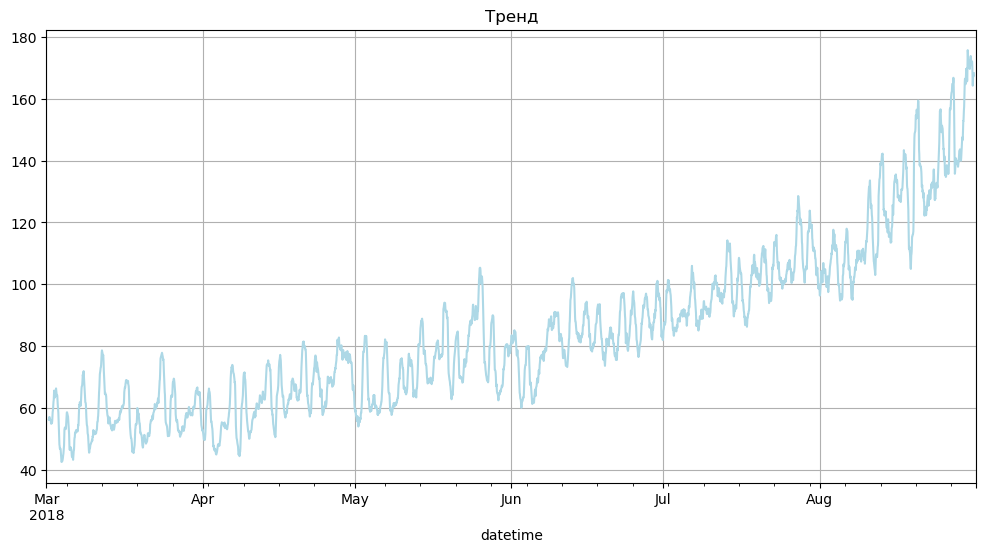

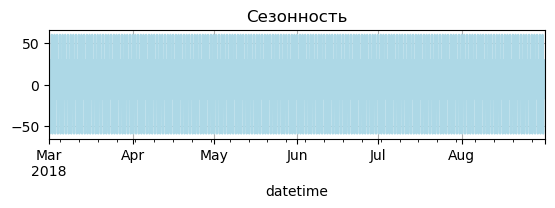

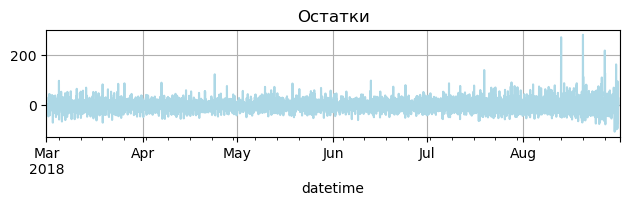

In [32]:
decomposed = seasonal_decompose(df['num_orders'].resample('1h').sum())

plt.figure(figsize=(12, 20))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca(), color='lightblue', grid=True)
plt.title('Тренд')
plt.show()

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), color='lightblue', grid=True)
plt.title('Сезонность')
plt.show()

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), color='lightblue', grid=True)
plt.title('Остатки')
plt.tight_layout()
plt.show()

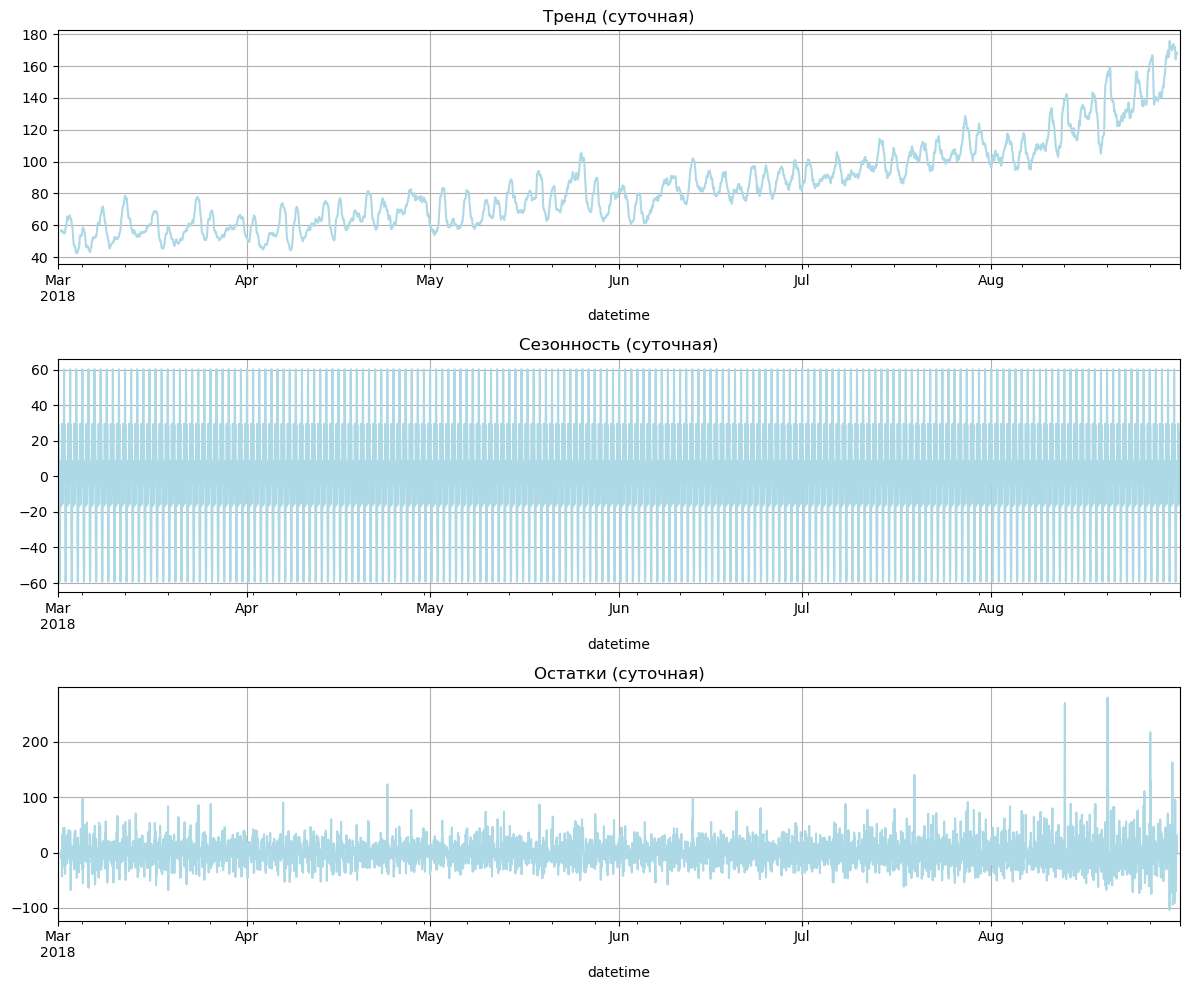

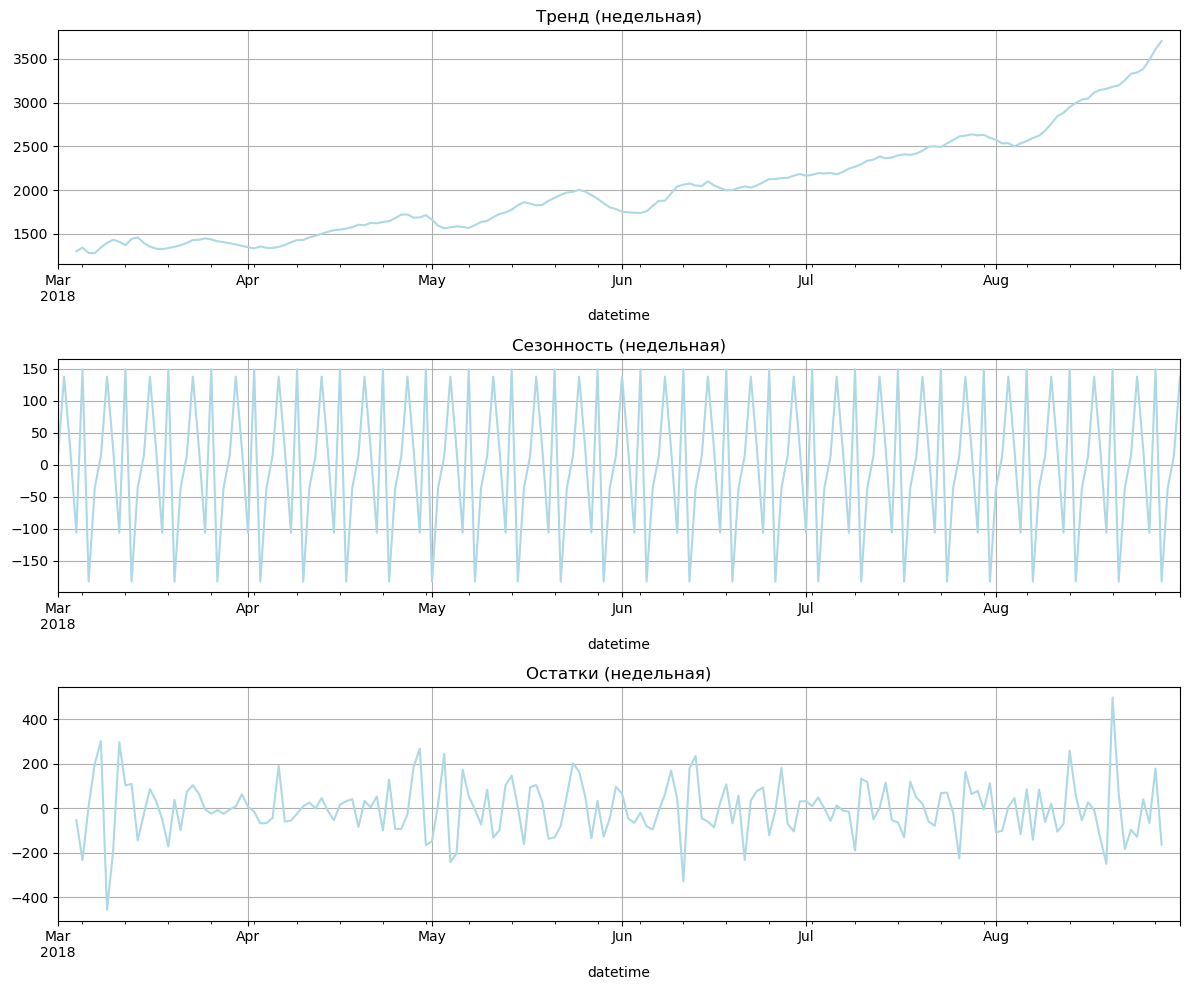

In [33]:
#Суточная сезонность
df_hourly = df['num_orders'].resample('1h').sum()

decomposed_day = seasonal_decompose(df_hourly, period=24)

plt.figure(figsize=(12, 10))

plt.subplot(311)
decomposed_day.trend.plot(ax=plt.gca(), color='lightblue', grid=True)
plt.title('Тренд (суточная)')

plt.subplot(312)
decomposed_day.seasonal.plot(ax=plt.gca(), color='lightblue', grid=True)
plt.title('Сезонность (суточная)')

plt.subplot(313)
decomposed_day.resid.plot(ax=plt.gca(), color='lightblue', grid=True)
plt.title('Остатки (суточная)')

plt.tight_layout()
plt.show()


#Недельная сезонность
df_daily = df['num_orders'].resample('1D').sum()

decomposed_week = seasonal_decompose(df_daily, period=7)

plt.figure(figsize=(12, 10))

plt.subplot(311)
decomposed_week.trend.plot(ax=plt.gca(), color='lightblue', grid=True)
plt.title('Тренд (недельная)')

plt.subplot(312)
decomposed_week.seasonal.plot(ax=plt.gca(), color='lightblue', grid=True)
plt.title('Сезонность (недельная)')

plt.subplot(313)
decomposed_week.resid.plot(ax=plt.gca(), color='lightblue', grid=True)
plt.title('Остатки (недельная)')

plt.tight_layout()
plt.show()


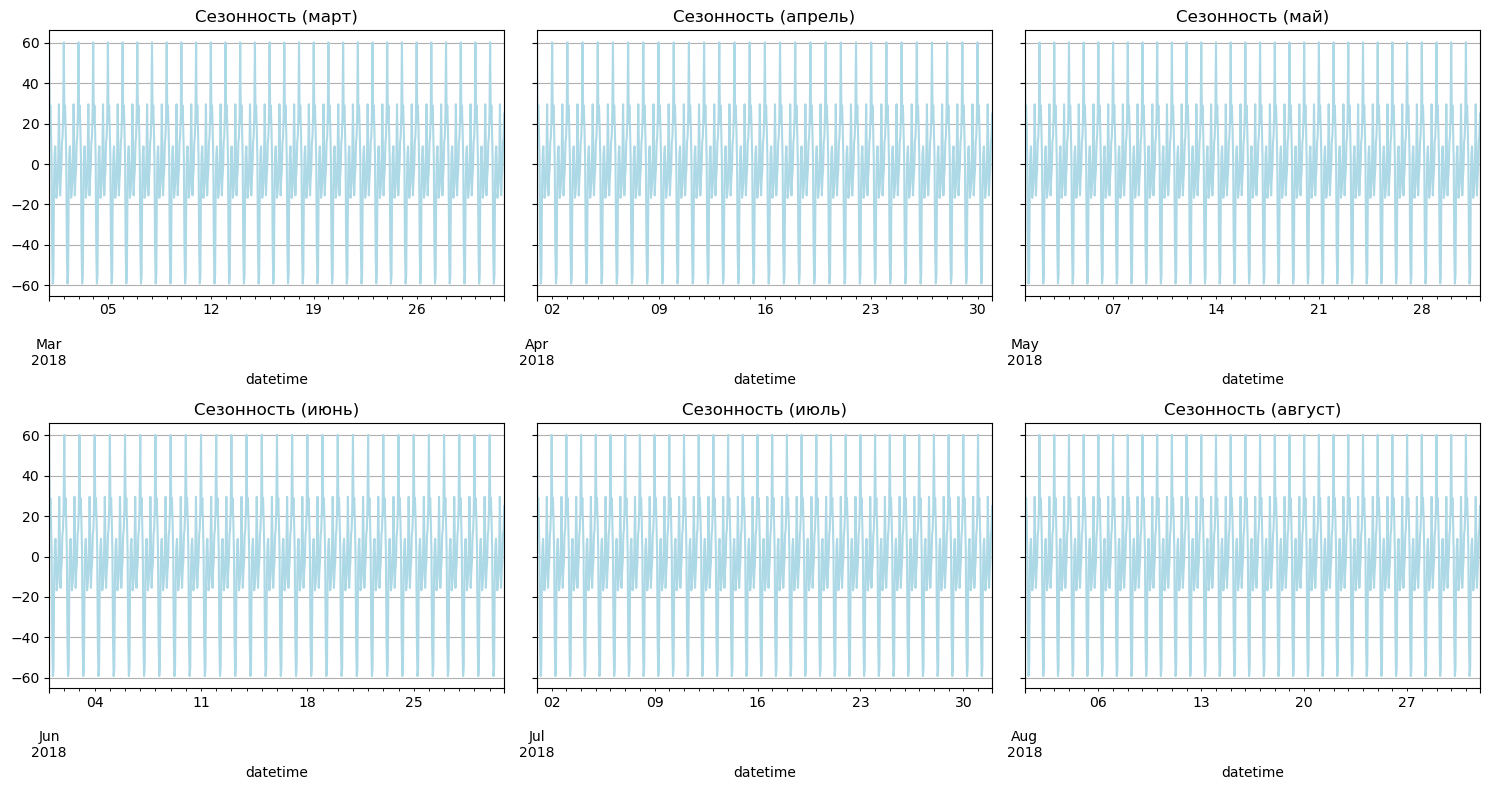

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True)
axes = axes.flatten()  

months = [
    ("2018-03-01", "2018-03-31", "Сезонность (март)"),
    ("2018-04-01", "2018-04-30", "Сезонность (апрель)"),
    ("2018-05-01", "2018-05-31", "Сезонность (май)"),
    ("2018-06-01", "2018-06-30", "Сезонность (июнь)"),
    ("2018-07-01", "2018-07-31", "Сезонность (июль)"),
    ("2018-08-01", "2018-08-31", "Сезонность (август)")
]

for ax, (start, end, title) in zip(axes, months):
    decomposed.seasonal[start:end].plot(ax=ax, color='lightblue', grid=True)
    ax.set_title(title)

plt.tight_layout()
plt.show()

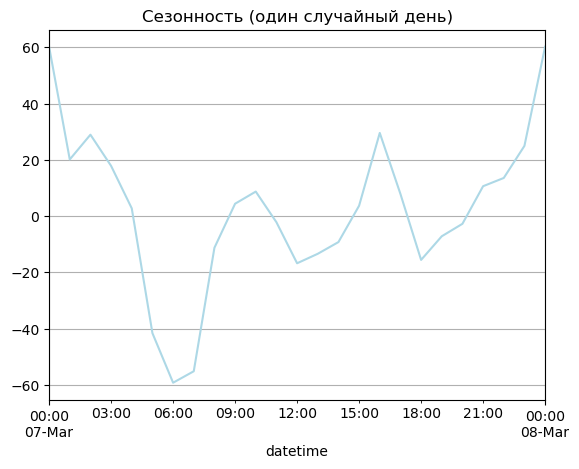

In [35]:
decomposed.seasonal['2018-03-07 00:00:00': '2018-03-08 00:00:00'].plot(ax=plt.gca(), color='lightblue', grid=True)
plt.title('Сезонность (один случайный день)')
plt.show()

Общий тренд направлен на постепенное увеличение количества заказов.

Результаты по каждому месяцу дают схожие результаты: каждый день наблюдается снижение количества поездок с 00:00 до 06:00, затем два пика в 09:00 и в 16:00.

### Выводы

Отмечено минимальное количество заказов в 5:00-6:00 утра; максимальное - в 0:00. Также есть рост количества заказов от начала к концу месяца.<br>
Если смотреть в целом - наблюдается позитивный тренд в количестве заказов. Присутствуют еженедельные колебания. Наиболее выражены тренд и сезонность в марте и апреле - в этих месяцах разброс остатков минимален.<br>
В августе присутствуют максимальные и нереаллистичные значения, обрабатывать которые было бы некорректно, однако, в то же время, они могут повлиять на качество моделей.

## Обучение моделей

### Подготвока данных

In [36]:
# Формируем датасет с дополнительными переменными
data = shift(df, 'num_orders', 1, 25, 1)
data = shift(df, 'num_orders', 48, 169, 24) 

In [37]:
# признак, в котором хранится час как число
data['hour'] = data.index.hour
# признак, в котором хранится день недели как число
data['weekday'] = data.index.dayofweek

In [38]:
data.head()

,num_orders,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,...,shift_23,shift_24,shift_48,shift_72,shift_96,shift_120,shift_144,shift_168,hour,weekday
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3
2018-03-01 01:00:00,85,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3
2018-03-01 02:00:00,71,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3
2018-03-01 03:00:00,66,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,3
2018-03-01 04:00:00,43,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,3


In [39]:
# Удаляем пропуски
data = data.dropna()

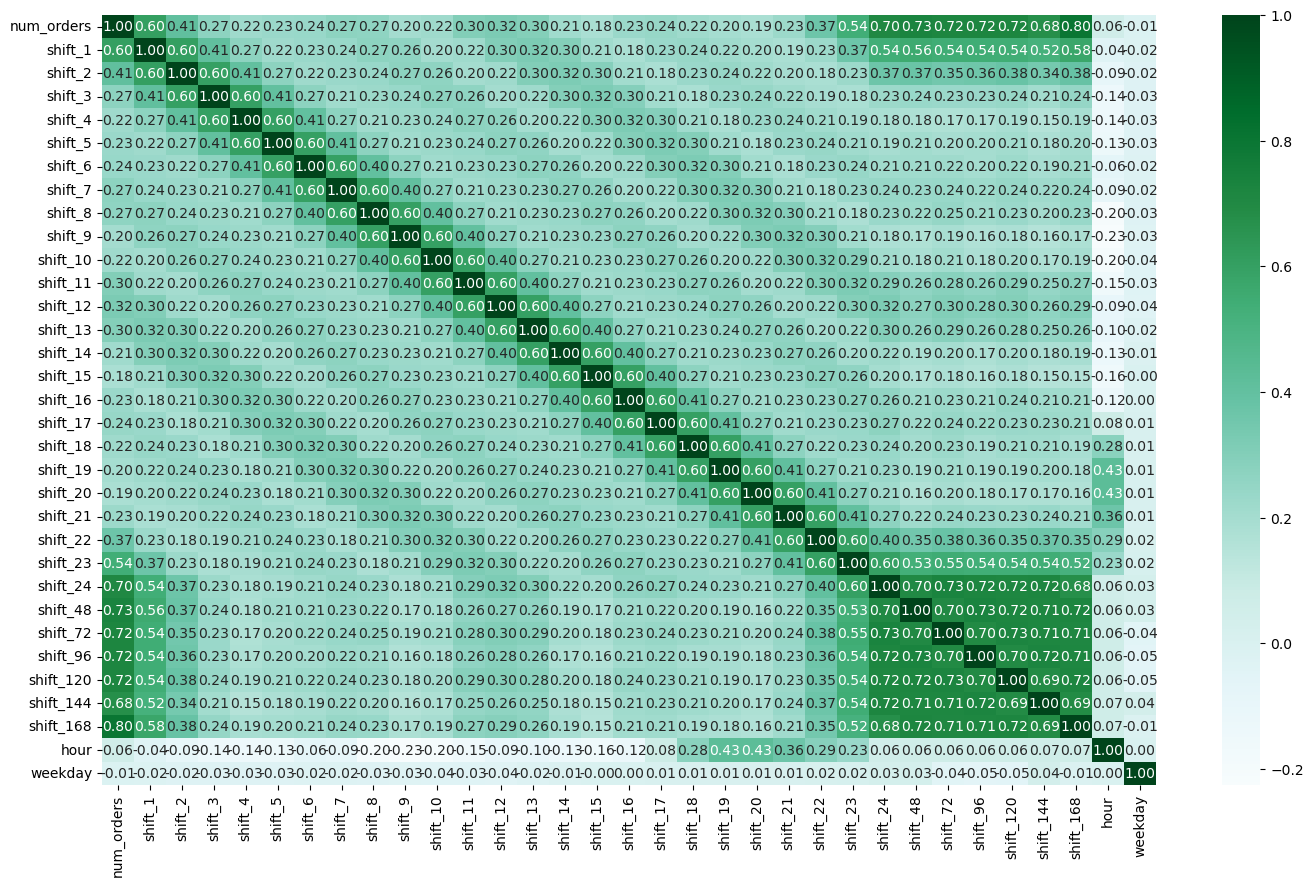

In [40]:
# Посмотрим наличие корреляции между признаками
plt.figure(figsize = (17,10))
sns.heatmap(data.corr(method="spearman"), annot=True, fmt='.2f', cmap='BuGn');
plt.show()

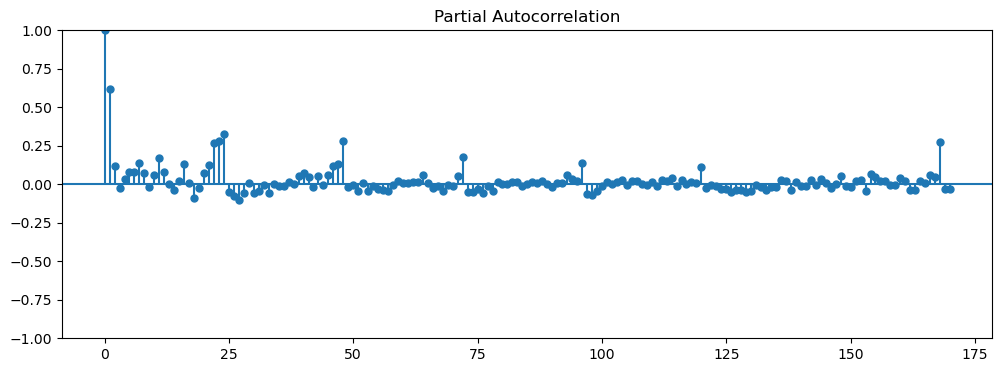

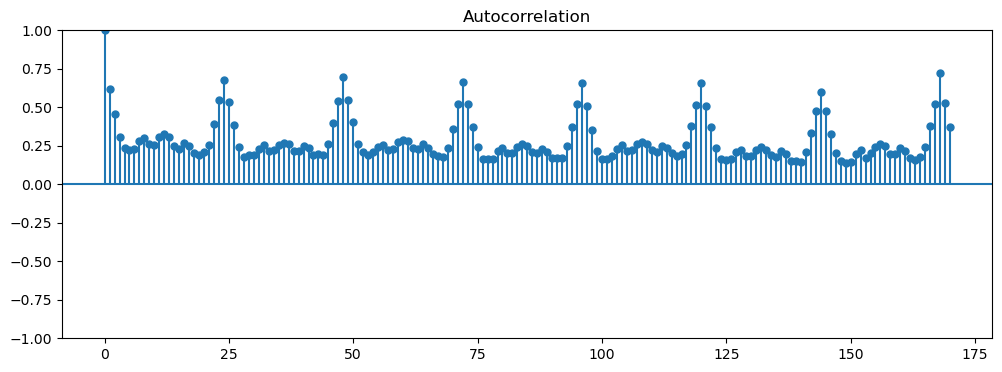

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(data['num_orders'], lags= 170, alpha=None).set_size_inches(12, 4)
plt.show()

plot_acf(data['num_orders'], lags= 170, alpha=None).set_size_inches(12, 4)
plt.show()

На графике автокорреляционной фукнции мы видим подъемы каждые 24 часа, это четкий сигнал о наличии суточной сезонности (ряд имеет существенную автокорреляцию на себя с шагом 24 часа). При этом на 168 заметен даже небольшой "подъем", что свидетельвует в пользу недельной сезонности.

Ожидаемо, что мы увидим корреляцию с целевым признаком, т.к. дополнительные были созданы на его основе. Тем не менее, корелляция практически всех признаков недостаточно высока, чтобы сказаться на работе модели. Единственное исключение - признак shift_168 (сдвиг на 168 часов) с корреляцией 0,8. 

In [42]:
data.head()

,num_orders,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,...,shift_23,shift_24,shift_48,shift_72,shift_96,shift_120,shift_144,shift_168,hour,weekday
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,51.0,...,121.0,100.0,42.0,86.0,75.0,163.0,90.0,124.0,0,3
2018-03-08 01:00:00,78,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,...,24.0,121.0,75.0,176.0,60.0,108.0,120.0,85.0,1,3
2018-03-08 02:00:00,65,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,...,66.0,24.0,36.0,32.0,26.0,25.0,75.0,71.0,2,3
2018-03-08 03:00:00,68,65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,...,73.0,66.0,49.0,51.0,42.0,64.0,64.0,66.0,3,3
2018-03-08 04:00:00,60,68.0,65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,...,10.0,73.0,30.0,34.0,27.0,44.0,20.0,43.0,4,3


In [43]:
# Разделим датафрейм на выборки
features_train,  features_test, target_train, target_test = data_preprocessing(data, 'num_orders')

print(features_train.shape[0], '{:.0%}'.format(features_train.shape[0]/data.shape[0]))
print(features_test.shape[0], '{:.0%}'.format(features_test.shape[0]/data.shape[0]))
print(target_train.shape[0], '{:.0%}'.format(target_train.shape[0]/data.shape[0]))
print(target_test.shape[0], '{:.0%}'.format(target_test.shape[0]/data.shape[0]))

3823 90%
425 10%
3823 90%
425 10%


In [44]:
data_grids = []
data_times = []

### LinearRegression

In [45]:
# LinearRegression
data_grids, data_times = grids_LinearRegression(
    features_train, 
    features_test, 
    target_train, 
    target_test, 
    data_grids, 
    data_times
)
print_model_result(data_grids, data_times, 'LinearRegression')

Модель   : LinearRegression
RMSE     : 22.13028537076874
Время    : 1.8463549613952637 секунд
Параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['shift_1', 'shift_2', 'shift_3', 'shift_4', 'shift_5', 'shift_6',
       'shift_7', 'shift_8', 'shift_9', 'shift_10', 'shift_11', 'shift_12',
       'shift_13', 'shift_14', 'shift_15', 'shift_16', 'shift_17', 'shift_18',
       'shift_19', 'shift_20', 'shift_21', 'shift_22', 'shift_23', 'shift_24',
       'shift_48', 'shift_72', 'shift_96', 'shift_120', 'shift_144',
       'shift_168', 'hour', 'weekday'],
      dtype='object'))])),
                ('regressor', LinearRegression())])


### DecisionTreeRegressor

In [46]:
# DecisionTreeRegressor
data_grids, data_times = grids_DecisionTreeRegressor(
    features_train, 
    features_test, 
    target_train, 
    target_test, 
    data_grids, 
    data_times
)
print_model_result(data_grids, data_times, 'DecisionTreeRegressor')

Модель   : DecisionTreeRegressor
RMSE     : 32.36158728104688
Время    : 0.3266792297363281 секунд
Параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['shift_1', 'shift_2', 'shift_3', 'shift_4', 'shift_5', 'shift_6',
       'shift_7', 'shift_8', 'shift_9', 'shift_10', 'shift_11', 'shift_12',
       'shift_13', 'shift_14', 'shift_15', 'shift_16', 'shift_17', 'shift_18',
       'shift_19', 'shift_20', 'shift_21', 'shift_22', 'shift_23', 'shift_24',
       'shift_48', 'shift_72', 'shift_96', 'shift_120', 'shift_144',
       'shift_168', 'hour', 'weekday'],
      dtype='object'))])),
                ('regressor',
                 DecisionTreeRegressor(max_depth=171, random_state=42))])


### RandomForestRegressor

In [47]:
# RandomForestRegressor 
data_grids, data_times = grids_RandomForestRegressor(
    features_train, 
    features_test, 
    target_train, 
    target_test, 
    data_grids, 
    data_times
)
print_model_result(data_grids, data_times, 'RandomForestRegressor')

Модель   : RandomForestRegressor
RMSE     : 32.6213281274381
Время    : 5.950682878494263 секунд
Параметры:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['shift_1', 'shift_2', 'shift_3', 'shift_4', 'shift_5', 'shift_6',
       'shift_7', 'shift_8', 'shift_9', 'shift_10', 'shift_11', 'shift_12',
       'shift_13', 'shift_14', 'shift_15', 'shift_16', 'shift_17', 'shift_18',
       'shift_19', 'shift_20', 'shift_21', 'shift_22', 'shift_23', 'shift_24',
       'shift_48', 'shift_72', 'shift_96', 'shift_120', 'shift_144',
       'shift_168', 'hour', 'weekday'],
      dtype='object'))])),
                ('regressor',
                 RandomForestRegressor(max_depth=60, n_estimators=1,
                               

### CatBoostRegressor

In [48]:
# CatBoostRegressor
data_grids, data_times = grids_CatBoostRegressor(
    features_train, 
    features_test, 
    target_train, 
    target_test, 
    data_grids, 
    data_times
)
print_model_result(data_grids, data_times, 'CatBoostRegressor')

Learning rate set to 0.050606
0:	learn: 37.7555063	total: 139ms	remaining: 2m 18s
1:	learn: 36.6766957	total: 141ms	remaining: 1m 10s
2:	learn: 35.6884119	total: 142ms	remaining: 47.3s
3:	learn: 34.7528070	total: 144ms	remaining: 35.8s
4:	learn: 33.8623939	total: 145ms	remaining: 28.9s
5:	learn: 33.0268801	total: 147ms	remaining: 24.3s
6:	learn: 32.2640694	total: 148ms	remaining: 21s
7:	learn: 31.5290152	total: 150ms	remaining: 18.5s
8:	learn: 30.8427286	total: 151ms	remaining: 16.6s
9:	learn: 30.2045201	total: 152ms	remaining: 15.1s
10:	learn: 29.6071965	total: 154ms	remaining: 13.8s
11:	learn: 29.0198715	total: 155ms	remaining: 12.8s
12:	learn: 28.4791833	total: 157ms	remaining: 11.9s
13:	learn: 27.9696075	total: 158ms	remaining: 11.1s
14:	learn: 27.5003780	total: 160ms	remaining: 10.5s
15:	learn: 27.0711275	total: 161ms	remaining: 9.91s
16:	learn: 26.6607612	total: 162ms	remaining: 9.4s
17:	learn: 26.2966638	total: 164ms	remaining: 8.94s
18:	learn: 25.9172263	total: 165ms	remaining:

### Выбор лучшей модели

In [49]:
# Лучшая модель из расчета RMSE
data_grids_best = data_grids[0]
data_times_best = data_times[0]
n = 0
for i in range(0, len(data_grids)):
    if data_grids[i].best_score_ < data_grids_best.best_score_: 
        data_grids_best = data_grids[i]
        data_times_best = data_times[i]

print('Лучшее время: ', data_times_best)
print('Лучшее RMSE: ', data_grids_best.best_score_)
print('Лучшая модель: ')
data_grids_best

Лучшее время:  1.8463549613952637
Лучшее RMSE:  22.13028537076874
Лучшая модель: 


,estimator,Pipeline(step...egression())])
,param_grid,[{'regressor': [LinearRegression()]}]
,factor,3
,resource,'n_samples'
,max_resources,'auto'
,min_resources,'exhaust'
,aggressive_elimination,False
,cv,TimeSeriesSpl...est_size=None)
,scoring,make_scorer(<...hod='predict')
,refit,True
,error_score,'raise'


Проведение тестирования:

In [50]:
start_time = time.time()

# Предсказание лучшей модели
predict = data_grids_best.predict(features_test)

finish_time = time.time()
funtion_time = finish_time - start_time

# Расчет RMSE и времени выполнения предсказания
rmse = np.sqrt(mean_squared_error(target_test, predict))
print('RMSE:', rmse)
print(f'Время предсказания: {funtion_time:.4f} секунд')

RMSE: 34.366017910953296
Время предсказания: 0.0029 секунд


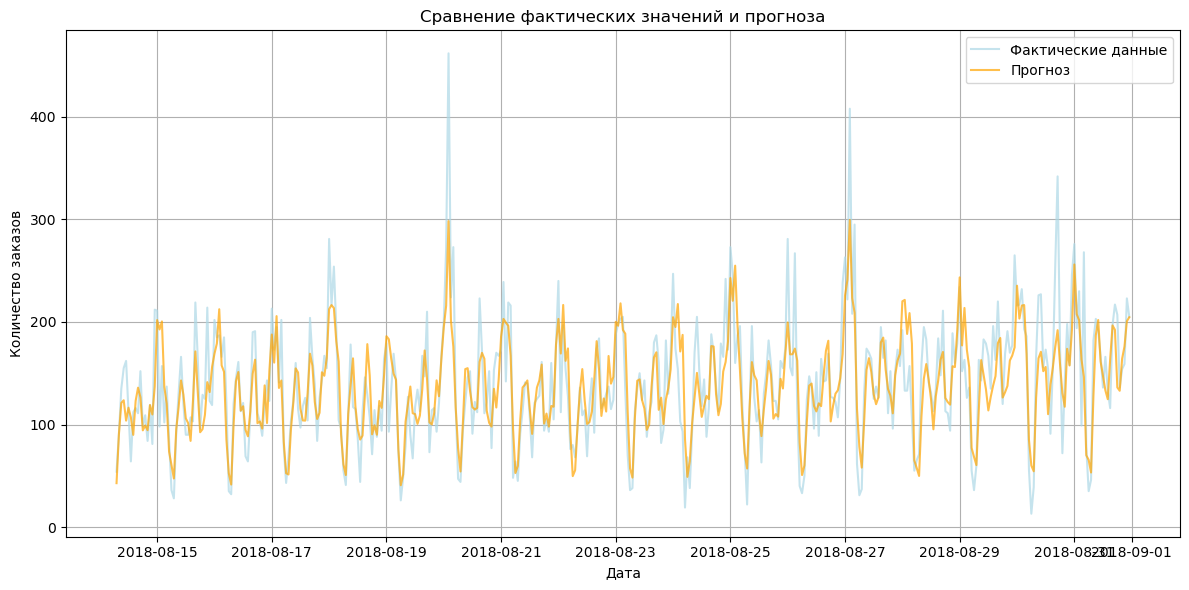

In [51]:
# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(target_test.index, target_test, label='Фактические данные', color='lightblue', alpha=0.7)
plt.plot(target_test.index, predict, label='Прогноз', color='orange', alpha=0.7)
plt.title('Сравнение фактических значений и прогноза')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [52]:
model_names = ['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor', 'CatBoostRegressor']
for i in range(0, len(data_grids)):
    print('Модель: ', model_names[i])
    print('RMSE: ', data_grids[i].best_score_)
    print('Время предсказания: ', data_times[i])
    print()

Модель:  LinearRegression
RMSE:  22.13028537076874
Время предсказания:  1.8463549613952637

Модель:  DecisionTreeRegressor
RMSE:  32.36158728104688
Время предсказания:  0.3266792297363281

Модель:  RandomForestRegressor
RMSE:  32.6213281274381
Время предсказания:  5.950682878494263

Модель:  CatBoostRegressor
RMSE:  22.361837569185646
Время предсказания:  7.55933403968811



### Выводы

По показателю RMSE лидирует LinearRegression, по времени она занимает второе место. В то же время CatBoostRegressor не сильно отличается в показателе RMSE, но отстает по времени.<br>
После проведения тестирования CatBoostRegressor показала более высокий показатель RMSE (34), но значительно снизила время предсказания (0,0029 секунд).

## Итоговый вывод

В ходе проекта:
- Был загружен и предобработан датасет, проведен первичный анализ признака
- Был проведен анализ сдвигов скользящих средних, а также декомпозиция количества заказов на сезонную и трендовую составляющие
- Было обучено и протестировано 4 модели регрессии (LinearRegression, DecisionTreeRegressor, RandomForestRegressor, CatBoostRegressor), проведен сравнительный анализ между ними на показатель RMSE и скорость предсказания.

По результатам проекта к использованию рекомендуется модель CatBoostRegressor с параметрами по умолчанию. Она показала хорошую скорость предсказания на тесте и значение RMSE = 34, что ниже требуемого в ТЗ. Кроме того, в ходе проекта было установлено, что предсказание путем использования сдвига на 1 неделю дает RMSE ниже, т.е. у модели есть потенциал к улучшению.